# ProteinMCP — Nanobody Design Workflow

Design nanobody CDR regions using BoltzGen with optimized cysteine filtering for single-domain antibodies (VHH).

| Component | Description |
|-----------|-------------|
| **BoltzGen** | Generative model for nanobody CDR loop design with structure prediction |
| **Async Jobs** | GPU-accelerated design with asynchronous job submission and monitoring |
| **Quality Metrics** | pTM, iPTM, pAE, H-bonds, delta SASA, cysteine filtering |

**Prerequisites:** Docker (with GPU support), Claude Code CLI, ProteinMCP installed locally.

**Links:** [GitHub](https://github.com/charlesxu90/ProteinMCP) · [BoltzGen](https://github.com/jwohlwend/boltzgen) · [Boltz2](https://github.com/jwohlwend/boltz)

---

## Job configs

In [1]:
# ── User Configuration ──
TARGET_NAME = "penguinpox"
TARGET_CIF_NAME = "9bkq-assembly2.cif"  # Target CIF file name
TARGET_CHAIN = "B"                       # Chain to design nanobody against
NUM_DESIGNS = 10                          # Number of nanobody designs to generate
BUDGET = 2                                # Computational budget (higher = more diverse)
CUDA_DEVICE = 1                           # GPU device to use (0 or 1)

# Optional: set API key here or in .env. If unset, Claude CLI uses your logged-in account.
ANTHROPIC_API_KEY = ""
CLAUDE_MODEL = "claude-sonnet-4-6"

## Import utility and define functions

In [2]:
import os
import subprocess
import json
import select

# ---------- Streaming command runner ----------
def run_cmd(cmd, cwd=None):
    """Run a shell command and stream stdout/stderr line-by-line in real time."""
    proc = subprocess.Popen(
        cmd, shell=True, cwd=cwd,
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
        bufsize=1, text=True,
    )
    for line in proc.stdout:
        print(line, end="", flush=True)
    proc.wait()
    if proc.returncode != 0:
        print(f"\n\u26a0\ufe0f  Command exited with code {proc.returncode}")
    return proc.returncode

# ---------- Claude streaming helper ----------
def _display_claude_line(line):
    """Parse a single stream-json line from Claude CLI and print progress."""
    if not line.strip():
        return
    try:
        data = json.loads(line)
        msg_type = data.get('type', '')
        subtype = data.get('subtype', '')

        if msg_type == 'system':
            if subtype == 'init':
                session_id = data.get('session_id', '')[:8]
                print(f"  \U0001f916 Session started: {session_id}...", flush=True)
            elif subtype != 'transcript':
                print(f"  \u2699\ufe0f  System: {subtype}", flush=True)

        elif msg_type == 'assistant':
            message = data.get('message', {})
            for block in message.get('content', []):
                block_type = block.get('type', '')
                if block_type == 'thinking':
                    text = block.get('thinking', '')[:100]
                    print(f"  \U0001f4ad Thinking: {text}...", flush=True)
                elif block_type == 'text':
                    lines = block.get('text', '').strip().split('\n')
                    for tl in lines[:5]:
                        if tl.strip():
                            print(f"  {tl}", flush=True)
                    if len(lines) > 5:
                        print(f"  ... ({len(lines) - 5} more lines)", flush=True)
                elif block_type == 'tool_use':
                    tool_name = block.get('name', 'unknown')
                    tool_input = block.get('input', {})
                    if tool_name == 'Bash':
                        print(f"  \U0001f527 Bash: {tool_input.get('command', '')[:80]}", flush=True)
                    elif tool_name in ('Read', 'Write', 'Edit'):
                        print(f"  \U0001f4d6 {tool_name}: {tool_input.get('file_path', '')}", flush=True)
                    elif tool_name.startswith('mcp__'):
                        print(f"  \U0001f50c MCP: {tool_name}", flush=True)
                    else:
                        print(f"  \U0001f527 {tool_name}", flush=True)

        elif msg_type == 'user':
            for block in data.get('message', {}).get('content', []):
                if block.get('type') == 'tool_result':
                    if block.get('is_error', False):
                        err = block.get('content', '')
                        err = err[:100] if isinstance(err, str) else str(err)[:100]
                        print(f"  \u274c Error: {err}", flush=True)
                    else:
                        content = block.get('content', '')
                        if isinstance(content, str) and content.strip():
                            first = content.strip().split('\n')[0][:80]
                            if first:
                                print(f"  \u2705 Result: {first}", flush=True)
                        else:
                            print(f"  \u2705 Done", flush=True)

        elif msg_type == 'result':
            if subtype == 'success':
                print(f"  \u2705 Completed successfully", flush=True)
            elif subtype == 'error':
                print(f"  \u274c Error: {data.get('error', 'Unknown')}", flush=True)

    except json.JSONDecodeError:
        if line.strip():
            print(f"  {line}", flush=True)


def run_claude(prompt, allowed_tools=None, cwd=None):
    """Run Claude CLI with real-time streaming output.

    Args:
        prompt: The prompt text to send to Claude (passed via stdin).
        allowed_tools: Comma-separated tool names, e.g. "Bash,Read,Write".
        cwd: Working directory for the claude process.

    Returns:
        Process return code (0 = success).
    """
    cmd = [
        "claude",
        "--model", CLAUDE_MODEL,
        "-p", "-",
        "--output-format", "stream-json",
        "--verbose",
        "--dangerously-skip-permissions",
    ]
    if allowed_tools:
        cmd += ["--allowedTools", allowed_tools]

    print(f"  \U0001f916 Claude model: {CLAUDE_MODEL}")
    print(f"  \U0001f4cb Tools: {allowed_tools or 'all'}")
    print(f"  " + "-" * 58)

    proc = subprocess.Popen(
        cmd, cwd=cwd,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True, bufsize=1,
    )
    proc.stdin.write(prompt)
    proc.stdin.close()

    while True:
        if proc.poll() is not None:
            # Drain remaining output
            for line in (proc.stdout.read() or '').split('\n'):
                _display_claude_line(line)
            for line in (proc.stderr.read() or '').split('\n'):
                if line.strip():
                    print(f"  \u2699\ufe0f  {line}", flush=True)
            break

        try:
            readable, _, _ = select.select([proc.stdout, proc.stderr], [], [], 0.1)
        except (ValueError, OSError):
            break

        for stream in readable:
            line = stream.readline()
            if line:
                if stream == proc.stdout:
                    _display_claude_line(line.rstrip('\n'))
                else:
                    if line.strip():
                        print(f"  \u2699\ufe0f  {line.rstrip()}", flush=True)

    rc = proc.wait()
    print(f"  " + "-" * 58)
    if rc != 0:
        print(f"  \u26a0\ufe0f  Claude exited with code {rc}")
    return rc

## Setup and verify the environment

In [3]:
import shutil

# ---------- Paths ----------
# Auto-detect REPO_DIR: walk up from notebook location to find project root
_nb_dir = os.path.abspath("")
if os.path.basename(_nb_dir) == "notebooks":
    REPO_DIR = os.path.dirname(_nb_dir)
else:
    REPO_DIR = _nb_dir

# ---------- Load API key from .env if not set ----------
if not ANTHROPIC_API_KEY:
    _env_file = os.path.join(REPO_DIR, ".env")
    if os.path.exists(_env_file):
        with open(_env_file) as f:
            for line in f:
                line = line.strip()
                if line.startswith("ANTHROPIC_API_KEY="):
                    ANTHROPIC_API_KEY = line.split("=", 1)[1].strip().strip("\"'")
                    break
        if ANTHROPIC_API_KEY:
            print(f"Loaded ANTHROPIC_API_KEY from {_env_file}")

if ANTHROPIC_API_KEY:
    os.environ["ANTHROPIC_API_KEY"] = ANTHROPIC_API_KEY
    print(f"Using API key (ends with ...{ANTHROPIC_API_KEY[-4:]})")
else:
    print("No API key set — Claude CLI will use your logged-in account.")

# ---------- Data paths ----------
EXAMPLE_DIR = os.path.join(REPO_DIR, "examples", "case3_nanobody_design")
DATA_DIR    = os.path.join(REPO_DIR, "data", TARGET_NAME)
RESULTS_DIR = os.path.join(REPO_DIR, "results", f"{TARGET_NAME}_nanobody")
TARGET_CIF  = os.path.join(DATA_DIR, TARGET_CIF_NAME)
SCAFFOLD_DIR = os.path.join(DATA_DIR, "nanobody_scaffolds")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "designs"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "logs"), exist_ok=True)
os.makedirs(SCAFFOLD_DIR, exist_ok=True)

# Copy example CIF into DATA_DIR
src_cif = os.path.join(EXAMPLE_DIR, TARGET_CIF_NAME)
if os.path.exists(src_cif) and not os.path.exists(TARGET_CIF):
    shutil.copy2(src_cif, TARGET_CIF)
    print(f"Copied {src_cif} -> {TARGET_CIF}")

# Copy example nanobody scaffolds into DATA_DIR
src_scaffold_dir = os.path.join(EXAMPLE_DIR, "nanobody_scaffolds")
if os.path.isdir(src_scaffold_dir):
    for fname in os.listdir(src_scaffold_dir):
        src = os.path.join(src_scaffold_dir, fname)
        dst = os.path.join(SCAFFOLD_DIR, fname)
        if os.path.isfile(src) and not os.path.exists(dst):
            shutil.copy2(src, dst)
    scaffold_files = [f for f in os.listdir(SCAFFOLD_DIR) if f.endswith(".yaml")]
    print(f"Copied {len(scaffold_files)} scaffold YAML files to {SCAFFOLD_DIR}")

assert os.path.exists(TARGET_CIF), f"Target CIF not found: {TARGET_CIF}"

# List scaffold files for config generation
SCAFFOLD_YAMLS = sorted(
    [os.path.join(SCAFFOLD_DIR, f) for f in os.listdir(SCAFFOLD_DIR) if f.endswith(".yaml")]
)

print(f"\nCLAUDE_MODEL     : {CLAUDE_MODEL}")
print(f"TARGET_NAME      : {TARGET_NAME}")
print(f"TARGET_CIF       : {TARGET_CIF}")
print(f"TARGET_CHAIN     : {TARGET_CHAIN}")
print(f"NUM_DESIGNS      : {NUM_DESIGNS}")
print(f"BUDGET           : {BUDGET}")
print(f"REPO_DIR         : {REPO_DIR}")
print(f"DATA_DIR         : {DATA_DIR}")
print(f"RESULTS_DIR      : {RESULTS_DIR}")
print(f"SCAFFOLD_YAMLS   : {[os.path.basename(f) for f in SCAFFOLD_YAMLS]}")

No API key set — Claude CLI will use your logged-in account.
Copied 4 scaffold YAML files to /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/nanobody_scaffolds

CLAUDE_MODEL     : claude-sonnet-4-6
TARGET_NAME      : penguinpox
TARGET_CIF       : /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/9bkq-assembly2.cif
TARGET_CHAIN     : B
NUM_DESIGNS      : 10
BUDGET           : 2
REPO_DIR         : /home/xux/Desktop/AgentMCP/ProteinMCP
DATA_DIR         : /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox
RESULTS_DIR      : /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody
SCAFFOLD_YAMLS   : ['7eow.yaml', '7xl0.yaml', '8coh.yaml', '8z8v.yaml']


## Install & Register MCPs

> **Tip — Local Docker build:** The `boltzgen_mcp` Docker image is large and may time out
> during `pmcp install`. You can build and register it locally instead:
> ```bash
> cd tool-mcps/boltzgen_mcp && docker build -t boltzgen_mcp:latest . && cd ../..
> claude mcp add boltzgen_mcp -- docker run -i --rm --gpus all --ipc=host -v $PWD:$PWD boltzgen_mcp:latest
> ```
> The install cell below will skip if `boltzgen_mcp` is already registered.

In [4]:
import time
_t0 = time.time()

# Install ProteinMCP if not already present
if run_cmd("which pmcp") != 0:
    run_cmd(f"pip install -e {REPO_DIR}")
    run_cmd(f"pip install -r {REPO_DIR}/requirements.txt")
else:
    print("ProteinMCP already installed.")

# Install Claude Code if not already present
if run_cmd("which claude") != 0:
    run_cmd("npm install -g @anthropic-ai/claude-code")
else:
    print("Claude Code already installed.")

# Verify Docker is available (required for boltzgen_mcp)
if run_cmd("docker --version") != 0:
    print("WARNING: Docker not found. boltzgen_mcp requires Docker with GPU support.")
else:
    print("Docker found.")

print(f"\nProteinMCP & Claude Code ready.")
print(f"Elapsed: {time.time() - _t0:.1f}s")

/home/xux/miniforge3/envs/protein-mcp/bin/pmcp
ProteinMCP already installed.
/home/xux/.local/bin/claude
Claude Code already installed.
Docker version 29.2.1, build a5c7197
Docker found.

ProteinMCP & Claude Code ready.
Elapsed: 0.0s


In [5]:
import time
_t0 = time.time()

# Check if boltzgen_mcp is already registered
_registered = subprocess.run(["claude", "mcp", "list"], capture_output=True, text=True).stdout
if "boltzgen_mcp" not in _registered:
    print("Installing boltzgen_mcp (this may take a while for the Docker image pull)...")
    run_cmd("pmcp install boltzgen_mcp", cwd=REPO_DIR)
else:
    print("boltzgen_mcp already registered. Skipping installation.")

# Verify MCP status
print(f"\n{'='*50}")
run_cmd("claude mcp list", cwd=REPO_DIR)
print(f"\nElapsed: {time.time() - _t0:.1f}s")

boltzgen_mcp already registered. Skipping installation.

Checking MCP server health...

msa_mcp: python /mnt/data/done_projects/2026/BioMolMCP/ProteinMCP/tool-mcps/msa_mcp/src/server.py - ✓ Connected
plmc_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP plmc_mcp:latest - ✓ Connected
ev_onehot_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP ev_onehot_mcp:latest - ✓ Connected
prottrans_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -e HOME=/home/xux -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP -v /home/xux/.cache:/home/xux/.cache prottrans_mcp:latest - ✓ Connected
bindcraft_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP bindcraft_mcp:latest -

## Step 1 — Prepare BoltzGen Configuration

In [6]:
import time
_t0 = time.time()

# Build BoltzGen config YAML directly (avoids Claude API issues)
config_path = os.path.join(RESULTS_DIR, "config.yaml")

scaffold_entries = "\n".join(f"        - {p}" for p in SCAFFOLD_YAMLS)

config_content = f"""\
entities:
  - file:
      path: {TARGET_CIF}
      include:
        - chain:
            id: {TARGET_CHAIN}

  - file:
      path:
{scaffold_entries}
"""

with open(config_path, "w") as f:
    f.write(config_content)

print(f"Config generated: {config_path}")
print(config_content)

# Verify all referenced files exist
print("--- Validation ---")
assert os.path.exists(TARGET_CIF), f"Target CIF not found: {TARGET_CIF}"
print(f"  Target CIF: {TARGET_CIF} OK")
for ypath in SCAFFOLD_YAMLS:
    assert os.path.exists(ypath), f"Scaffold YAML not found: {ypath}"
    # Check CIF referenced in scaffold YAML
    cif_name = os.path.splitext(os.path.basename(ypath))[0] + ".cif"
    cif_path = os.path.join(os.path.dirname(ypath), cif_name)
    assert os.path.exists(cif_path), f"Scaffold CIF not found: {cif_path}"
    print(f"  Scaffold: {os.path.basename(ypath)} + {cif_name} OK")
print("All files validated.")

print(f"\nElapsed: {time.time() - _t0:.1f}s")

Config generated: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/config.yaml
entities:
  - file:
      path: /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/9bkq-assembly2.cif
      include:
        - chain:
            id: B

  - file:
      path:
        - /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/nanobody_scaffolds/7eow.yaml
        - /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/nanobody_scaffolds/7xl0.yaml
        - /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/nanobody_scaffolds/8coh.yaml
        - /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/nanobody_scaffolds/8z8v.yaml

--- Validation ---
  Target CIF: /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/9bkq-assembly2.cif OK
  Scaffold: 7eow.yaml + 7eow.cif OK
  Scaffold: 7xl0.yaml + 7xl0.cif OK
  Scaffold: 8coh.yaml + 8coh.cif OK
  Scaffold: 8z8v.yaml + 8z8v.cif OK
All files validated.

Elapsed: 0.0s


## Step 2 — Validate Configuration

In [7]:
import time
_t0 = time.time()

config_path = os.path.join(RESULTS_DIR, "config.yaml")

prompt = f"""\
Validate the BoltzGen configuration at {config_path}.
Check that:
1. The YAML structure has correct 'entities' format
2. The target CIF file exists at the path specified
3. All scaffold YAML files exist
4. Each scaffold YAML references a CIF file that also exists
"""

run_claude(
    prompt,
    allowed_tools="Bash,Read",
    cwd=REPO_DIR,
)

print(f"\nElapsed: {time.time() - _t0:.1f}s")

  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: Bash,Read
  ----------------------------------------------------------
  🤖 Session started: 005b9e71...
  💭 Thinking: Let me read the BoltzGen configuration file and validate it....
  📖 Read: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/config.yaml
  ✅ Result: 1→entities:
  💭 Thinking: Now let me check if the target CIF file and all scaffold YAML files exist....
  🔧 Bash: ls /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/9bkq-assembly2.cif 2>&1
  🔧 Glob
  ✅ Result: /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/9bkq-assembly2.cif
  ✅ Result: /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/nanobody_scaffolds/7eow.ya
  All 4 scaffold YAMLs exist. Now let me check what CIF files each references.
  📖 Read: /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/nanobody_scaffolds/7eow.yaml
  ✅ Result: 1→# caplacizumab
  📖 Read: /home/xux/Desktop/AgentMCP/ProteinMCP/data/penguinpox/nanobody_scaffolds/7xl0.

## Step 3 — Launch Nanobody Design Job

> **Note:** The design job is launched directly via `docker run` (detached) rather
> than through `boltzgen_submit`, because the MCP Docker container uses `--rm` and
> is killed when the Claude CLI session ends — which would kill the background
> BoltzGen process. Running the container in detached mode (`-d`) ensures
> the GPU job survives across notebook cells.

In [8]:
import time
_t0 = time.time()

config_path = os.path.join(RESULTS_DIR, "config.yaml")
designs_dir = os.path.join(RESULTS_DIR, "designs")
assert os.path.isfile(config_path), f"Config file not found: {config_path}"

os.makedirs(designs_dir, exist_ok=True)
print(f"Config file : {config_path}")
print(f"Output dir  : {designs_dir}")
print(f"Protocol    : nanobody-anything")
print(f"Num designs : {NUM_DESIGNS}")
print(f"Budget      : {BUDGET}")
print(f"CUDA device : {CUDA_DEVICE}")

# Launch BoltzGen in a detached Docker container (survives notebook cell transitions)
CONTAINER_NAME = f"boltzgen_job_{TARGET_NAME}"

# Kill any previous container with the same name
subprocess.run(["docker", "rm", "-f", CONTAINER_NAME], capture_output=True)

docker_cmd = [
    "docker", "run", "-d",
    "--name", CONTAINER_NAME,
    "--user", f"{os.getuid()}:{os.getgid()}",
    "--gpus", "all", "--ipc=host",
    "-v", f"{REPO_DIR}:{REPO_DIR}",
    "-e", f"CUDA_VISIBLE_DEVICES={CUDA_DEVICE}",
    "-e", "PYTHONUNBUFFERED=1",
    "-e", "MASTER_ADDR=127.0.0.1",
    "-e", "MASTER_PORT=29500",
    "-e", "GLOO_SOCKET_IFNAME=lo",
    "-e", "NCCL_SOCKET_FAMILY=AF_INET",
    "-e", "NCCL_SOCKET_IFNAME=lo",
    "boltzgen_mcp:latest",
    "python", "/app/scripts/run_boltzgen.py",
    "--config", config_path,
    "--output", designs_dir,
    "--protocol", "nanobody-anything",
    "--num_designs", str(NUM_DESIGNS),
    "--budget", str(BUDGET),
    "--log_file", os.path.join(designs_dir, "boltzgen_run.log"),
]

result = subprocess.run(docker_cmd, capture_output=True, text=True)
if result.returncode == 0:
    container_id = result.stdout.strip()[:12]
    print(f"\nContainer launched: {container_id} ({CONTAINER_NAME})")
    print("GPU job is running in the background. Use the polling cell to monitor.")
else:
    print(f"ERROR launching container:\n{result.stderr}")

print(f"Elapsed: {time.time() - _t0:.1f}s")

Config file : /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/config.yaml
Output dir  : /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/designs
Protocol    : nanobody-anything
Num designs : 10
Budget      : 2
CUDA device : 1

Container launched: 357f8abb85ce (boltzgen_job_penguinpox)
GPU job is running in the background. Use the polling cell to monitor.
Elapsed: 2.4s


## Step 4 — Monitor Job Progress

In [9]:
import time
_t0 = time.time()

designs_dir = os.path.join(RESULTS_DIR, "designs")
LOG_FILE = os.path.join(designs_dir, "boltzgen_run.log")
CONTAINER_NAME = f"boltzgen_job_{TARGET_NAME}"

# Check container status
_cstatus = subprocess.run(
    ["docker", "inspect", "-f", "{{.State.Status}}", CONTAINER_NAME],
    capture_output=True, text=True
).stdout.strip()
print(f"Container '{CONTAINER_NAME}' status: {_cstatus or 'not found'}")

# Check GPU
_gpu = subprocess.run(
    ["nvidia-smi", "--query-gpu=index,utilization.gpu,memory.used", "--format=csv,noheader"],
    capture_output=True, text=True
).stdout.strip()
print(f"GPU status: {_gpu}")

# Count design files
import glob as glob_mod
cif_files = glob_mod.glob(os.path.join(designs_dir, "**/*.cif"), recursive=True)
print(f"Design CIF files: {len(cif_files)}")

# Show recent log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE) as f:
        lines = f.readlines()
    print(f"\nLog ({len(lines)} lines), last 15:")
    for line in lines[-15:]:
        print(f"  {line.rstrip()}")
else:
    print(f"\nNo log file yet at {LOG_FILE}")

print(f"\nElapsed: {time.time() - _t0:.1f}s")

Container 'boltzgen_job_penguinpox' status: running
GPU status: 0, 0 %, 31293 MiB
1, 0 %, 441 MiB
Design CIF files: 0

Log (13 lines), last 15:
  2026-02-22 06:46:59 | INFO     | Logging to file: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/designs/boltzgen_run.log
  2026-02-22 06:46:59 | INFO     | ================================================================================
  2026-02-22 06:46:59 | INFO     | BoltzGen Runner
  2026-02-22 06:46:59 | INFO     | ================================================================================
  2026-02-22 06:46:59 | INFO     | Running BoltzGen with command:
  2026-02-22 06:46:59 | INFO     |   boltzgen run /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/config.yaml --output /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/designs --protocol nanobody-anything --num_designs 10 --budget 2
  2026-02-22 06:46:59 | INFO     | Config: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguin

### Polling Loop (Optional)

Run this cell to poll job status every 60 seconds until the job completes.
Interrupt the kernel to stop polling early.

In [10]:
import time
import glob as glob_mod

POLL_INTERVAL = 60   # seconds
MAX_POLLS = 30       # stop after 30 minutes

designs_dir = os.path.join(RESULTS_DIR, "designs")
LOG_FILE = os.path.join(designs_dir, "boltzgen_run.log")
CONTAINER_NAME = f"boltzgen_job_{TARGET_NAME}"

print(f"Polling {designs_dir} every {POLL_INTERVAL}s (Ctrl+C to stop)\n")

for i in range(1, MAX_POLLS + 1):
    # Count design files
    cif_files = glob_mod.glob(os.path.join(designs_dir, "**/*.cif"), recursive=True)
    n_designs = len(cif_files)

    # Check container status
    _cstatus = subprocess.run(
        ["docker", "inspect", "-f", "{{.State.Status}}", CONTAINER_NAME],
        capture_output=True, text=True
    ).stdout.strip()

    # Read last log line for current stage
    last_line = ""
    if os.path.exists(LOG_FILE):
        with open(LOG_FILE) as f:
            lines = f.readlines()
            if lines:
                last_line = lines[-1].strip()[:120]

    ts = time.strftime("%H:%M:%S")
    print(f"[{ts}] Poll #{i}: designs={n_designs} container={_cstatus} | {last_line}")

    # Check if container exited (job completed or failed)
    if _cstatus == "exited":
        _exit_code = subprocess.run(
            ["docker", "inspect", "-f", "{{.State.ExitCode}}", CONTAINER_NAME],
            capture_output=True, text=True
        ).stdout.strip()
        if _exit_code == "0":
            print(f"\nJob completed successfully with {n_designs} design files.")
        else:
            print(f"\nContainer exited with code {_exit_code}.")
            print(f"Check log: tail -30 {LOG_FILE}")
        break

    if not _cstatus or _cstatus == "not found":
        print(f"\nContainer not found. Job may not have started.")
        break

    # Check for completion markers in log
    if "Pipeline completed" in last_line or "completed successfully" in last_line.lower():
        print(f"\nJob completed! {n_designs} design files generated.")
        break

    time.sleep(POLL_INTERVAL)
else:
    print(f"\nMax polls reached ({MAX_POLLS}). Check status manually.")

Polling /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/designs every 60s (Ctrl+C to stop)

[09:46:59] Poll #1: designs=0 container=running | 2026-02-22 06:46:59 | INFO     | --------------------------------------------------------------------------------
[09:47:59] Poll #2: designs=1 container=running | 2026-02-22 06:47:08 | INFO     | [BoltzGen] Running command: /usr/local/bin/python3.12 /usr/local/lib/python3.12/site-pa
[09:48:59] Poll #3: designs=1 container=running | 2026-02-22 06:48:35 | INFO     | [BoltzGen]   warnings.warn(
[09:49:59] Poll #4: designs=4 container=running | 2026-02-22 06:49:54 | INFO     | [BoltzGen]   return data.pin_memory(device)
[09:50:59] Poll #5: designs=6 container=running | 2026-02-22 06:50:43 | INFO     | [BoltzGen] Switched checkpoint.
[09:52:00] Poll #6: designs=9 container=running | 2026-02-22 06:51:54 | INFO     | [BoltzGen]   warnings.warn(
[09:53:00] Poll #7: designs=13 container=running | 2026-02-22 06:52:59 | INFO     | [BoltzG

## Step 5 — Retrieve Results

In [11]:
import time
import glob as glob_mod
_t0 = time.time()

designs_dir = os.path.join(RESULTS_DIR, "designs")
LOG_FILE = os.path.join(designs_dir, "boltzgen_run.log")
CONTAINER_NAME = f"boltzgen_job_{TARGET_NAME}"

# Check container final status
_cstatus = subprocess.run(
    ["docker", "inspect", "-f", "{{.State.Status}}", CONTAINER_NAME],
    capture_output=True, text=True
).stdout.strip()
_exit_code = subprocess.run(
    ["docker", "inspect", "-f", "{{.State.ExitCode}}", CONTAINER_NAME],
    capture_output=True, text=True
).stdout.strip()
print(f"Container: {_cstatus} (exit code: {_exit_code})")

# List output files (CIF and PDB)
cif_files = sorted(glob_mod.glob(os.path.join(designs_dir, "**/*.cif"), recursive=True))
pdb_files = sorted(glob_mod.glob(os.path.join(designs_dir, "**/*.pdb"), recursive=True))

if cif_files:
    print(f"\nDesign CIF outputs ({len(cif_files)} files):")
    for f in cif_files:
        print(f"  {os.path.relpath(f, RESULTS_DIR)}")
if pdb_files:
    print(f"\nDesign PDB outputs ({len(pdb_files)} files):")
    for f in pdb_files:
        print(f"  {os.path.relpath(f, RESULTS_DIR)}")
if not cif_files and not pdb_files:
    print("\nNo design structure files found. Job may still be running or failed.")
    if os.path.exists(LOG_FILE):
        print(f"Check log: tail -30 {LOG_FILE}")

# Print metrics if available
for pattern in ["**/metrics.csv", "**/design_metrics.csv", "**/all_designs_metrics.csv", "**/*stats*.csv"]:
    for csv_path in glob_mod.glob(os.path.join(designs_dir, pattern), recursive=True):
        try:
            import pandas as pd
            df = pd.read_csv(csv_path)
            print(f"\nMetrics from {os.path.relpath(csv_path, designs_dir)}:")
            print(df.to_string(index=False))
        except Exception as e:
            print(f"\nCould not read {csv_path}: {e}")
        break

print(f"\nElapsed: {time.time() - _t0:.1f}s")

Container: exited (exit code: 0)

Design CIF outputs (55 files):
  designs/config.cif
  designs/final_ranked_designs/final_2_designs/before_refolding/rank01_config_9.cif
  designs/final_ranked_designs/final_2_designs/before_refolding/rank02_config_1.cif
  designs/final_ranked_designs/final_2_designs/rank01_config_9.cif
  designs/final_ranked_designs/final_2_designs/rank02_config_1.cif
  designs/final_ranked_designs/intermediate_ranked_10_designs/before_refolding/rank00_config_9.cif
  designs/final_ranked_designs/intermediate_ranked_10_designs/before_refolding/rank01_config_1.cif
  designs/final_ranked_designs/intermediate_ranked_10_designs/before_refolding/rank02_config_4.cif
  designs/final_ranked_designs/intermediate_ranked_10_designs/before_refolding/rank03_config_5.cif
  designs/final_ranked_designs/intermediate_ranked_10_designs/before_refolding/rank04_config_6.cif
  designs/final_ranked_designs/intermediate_ranked_10_designs/before_refolding/rank05_config_8.cif
  designs/final_ra

## Step 6 — Visualize Results

Loaded 10 designs from /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/designs/final_ranked_designs/all_designs_metrics.csv
Status: 0 Passed, 10 Failed
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/figures/nanobody_design_quality_score.png
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/figures/nanobody_design_structure_quality.png
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/figures/nanobody_design_normalized_heatmap.png
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/figures/nanobody_design_statistics_table.png
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/figures/nanobody_design_quality_boxplot.png
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/figures/nanobody_design_interface_metrics.png
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/penguinpox_nanobody/figures/nanobody_design_top5_designs.png
Saved: /

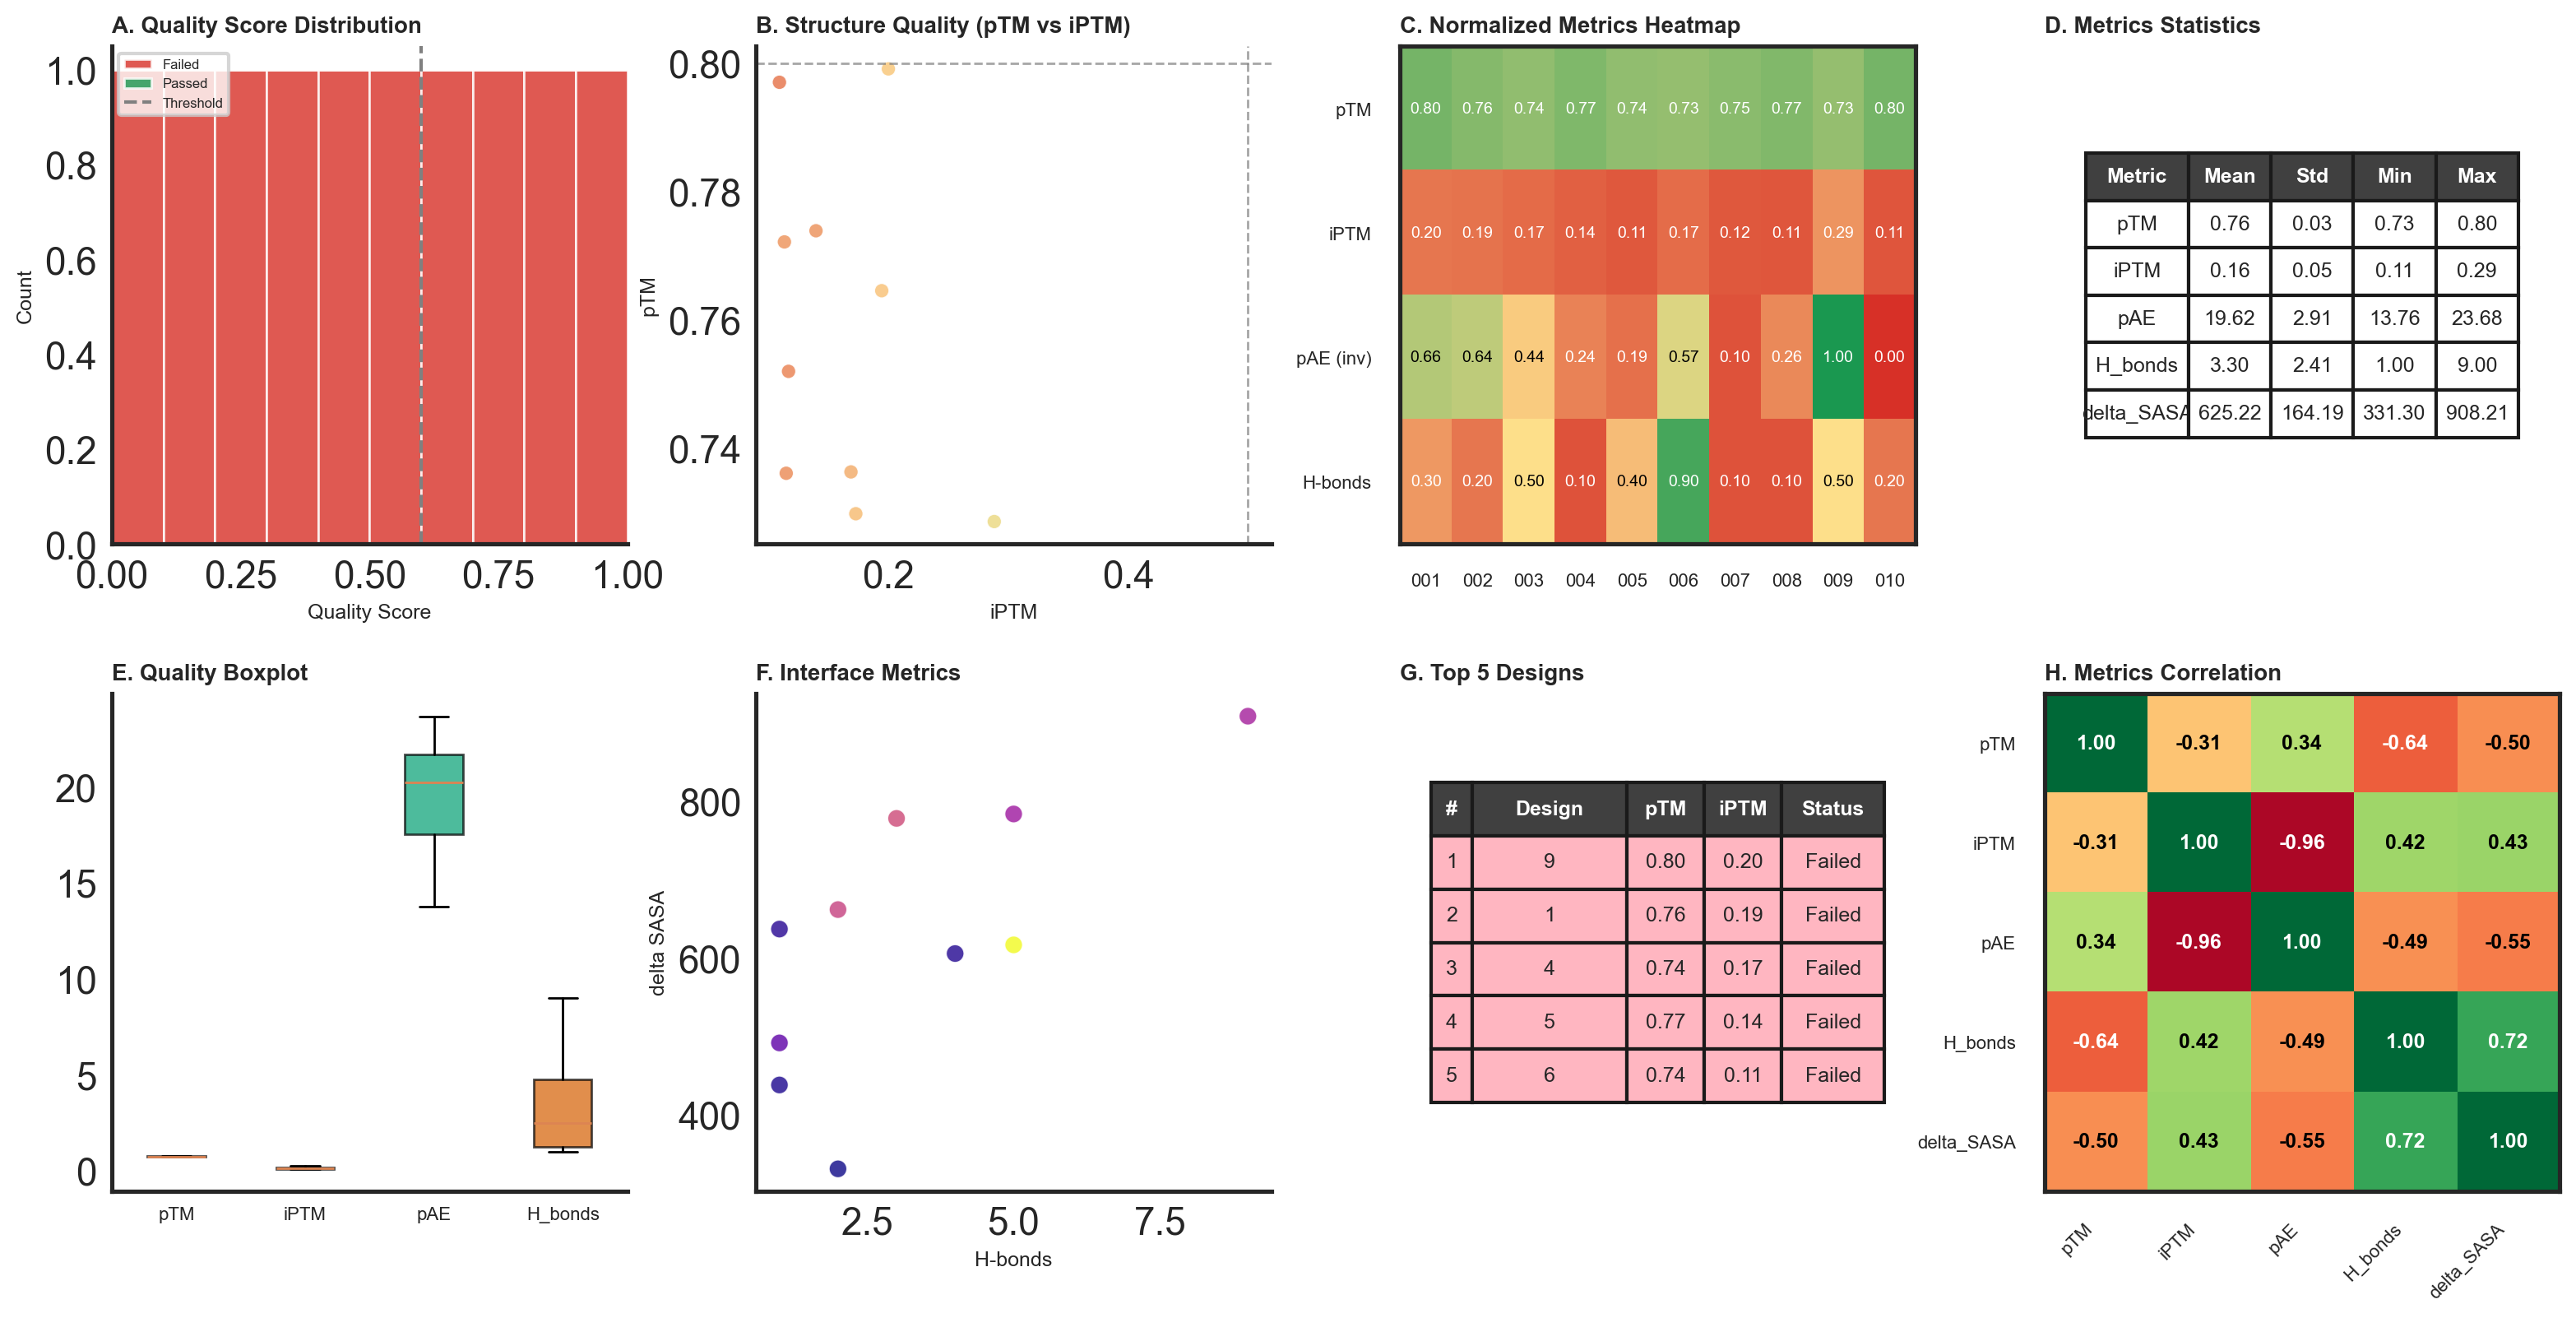


nanobody_design_quality_score.png:


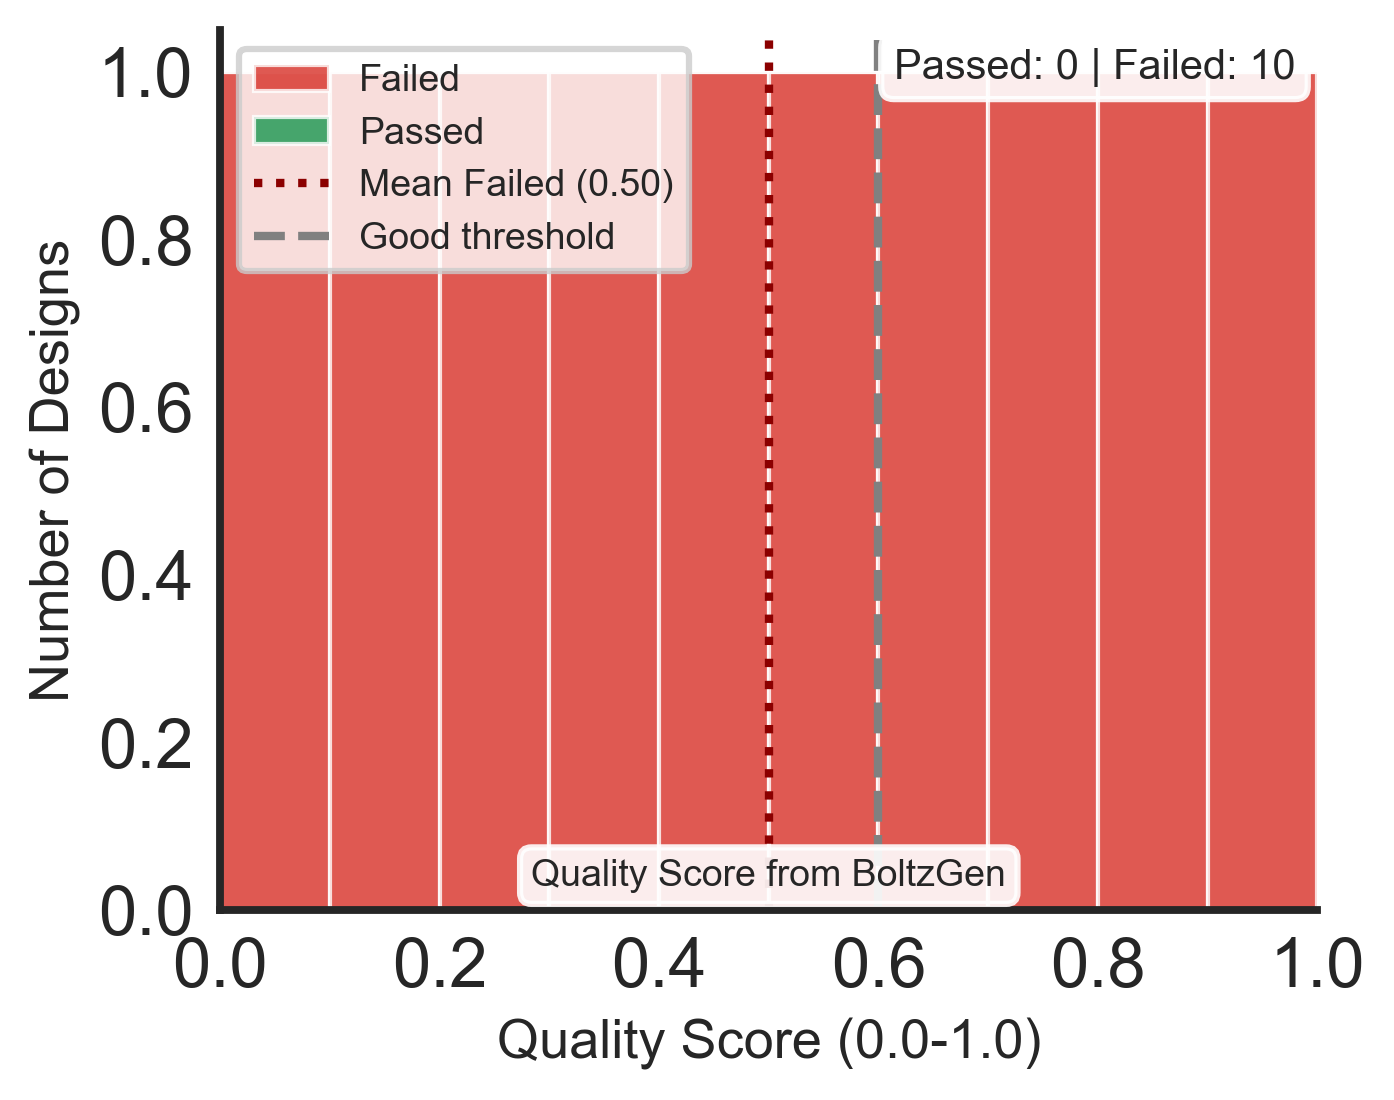


nanobody_design_structure_quality.png:


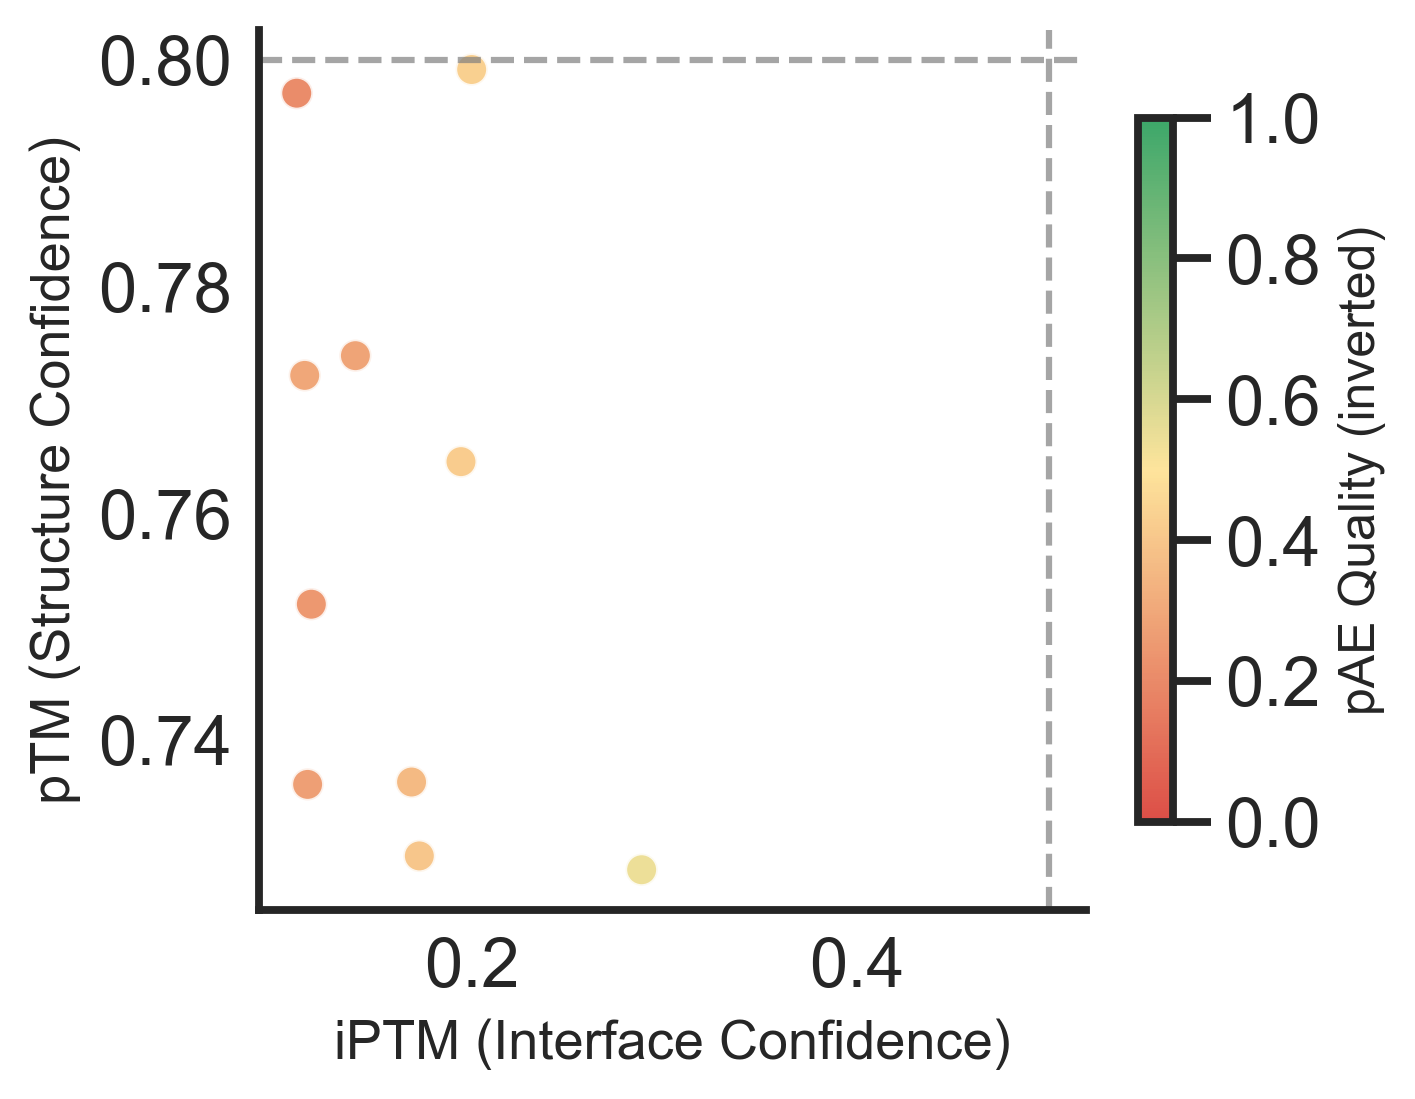


nanobody_design_normalized_heatmap.png:


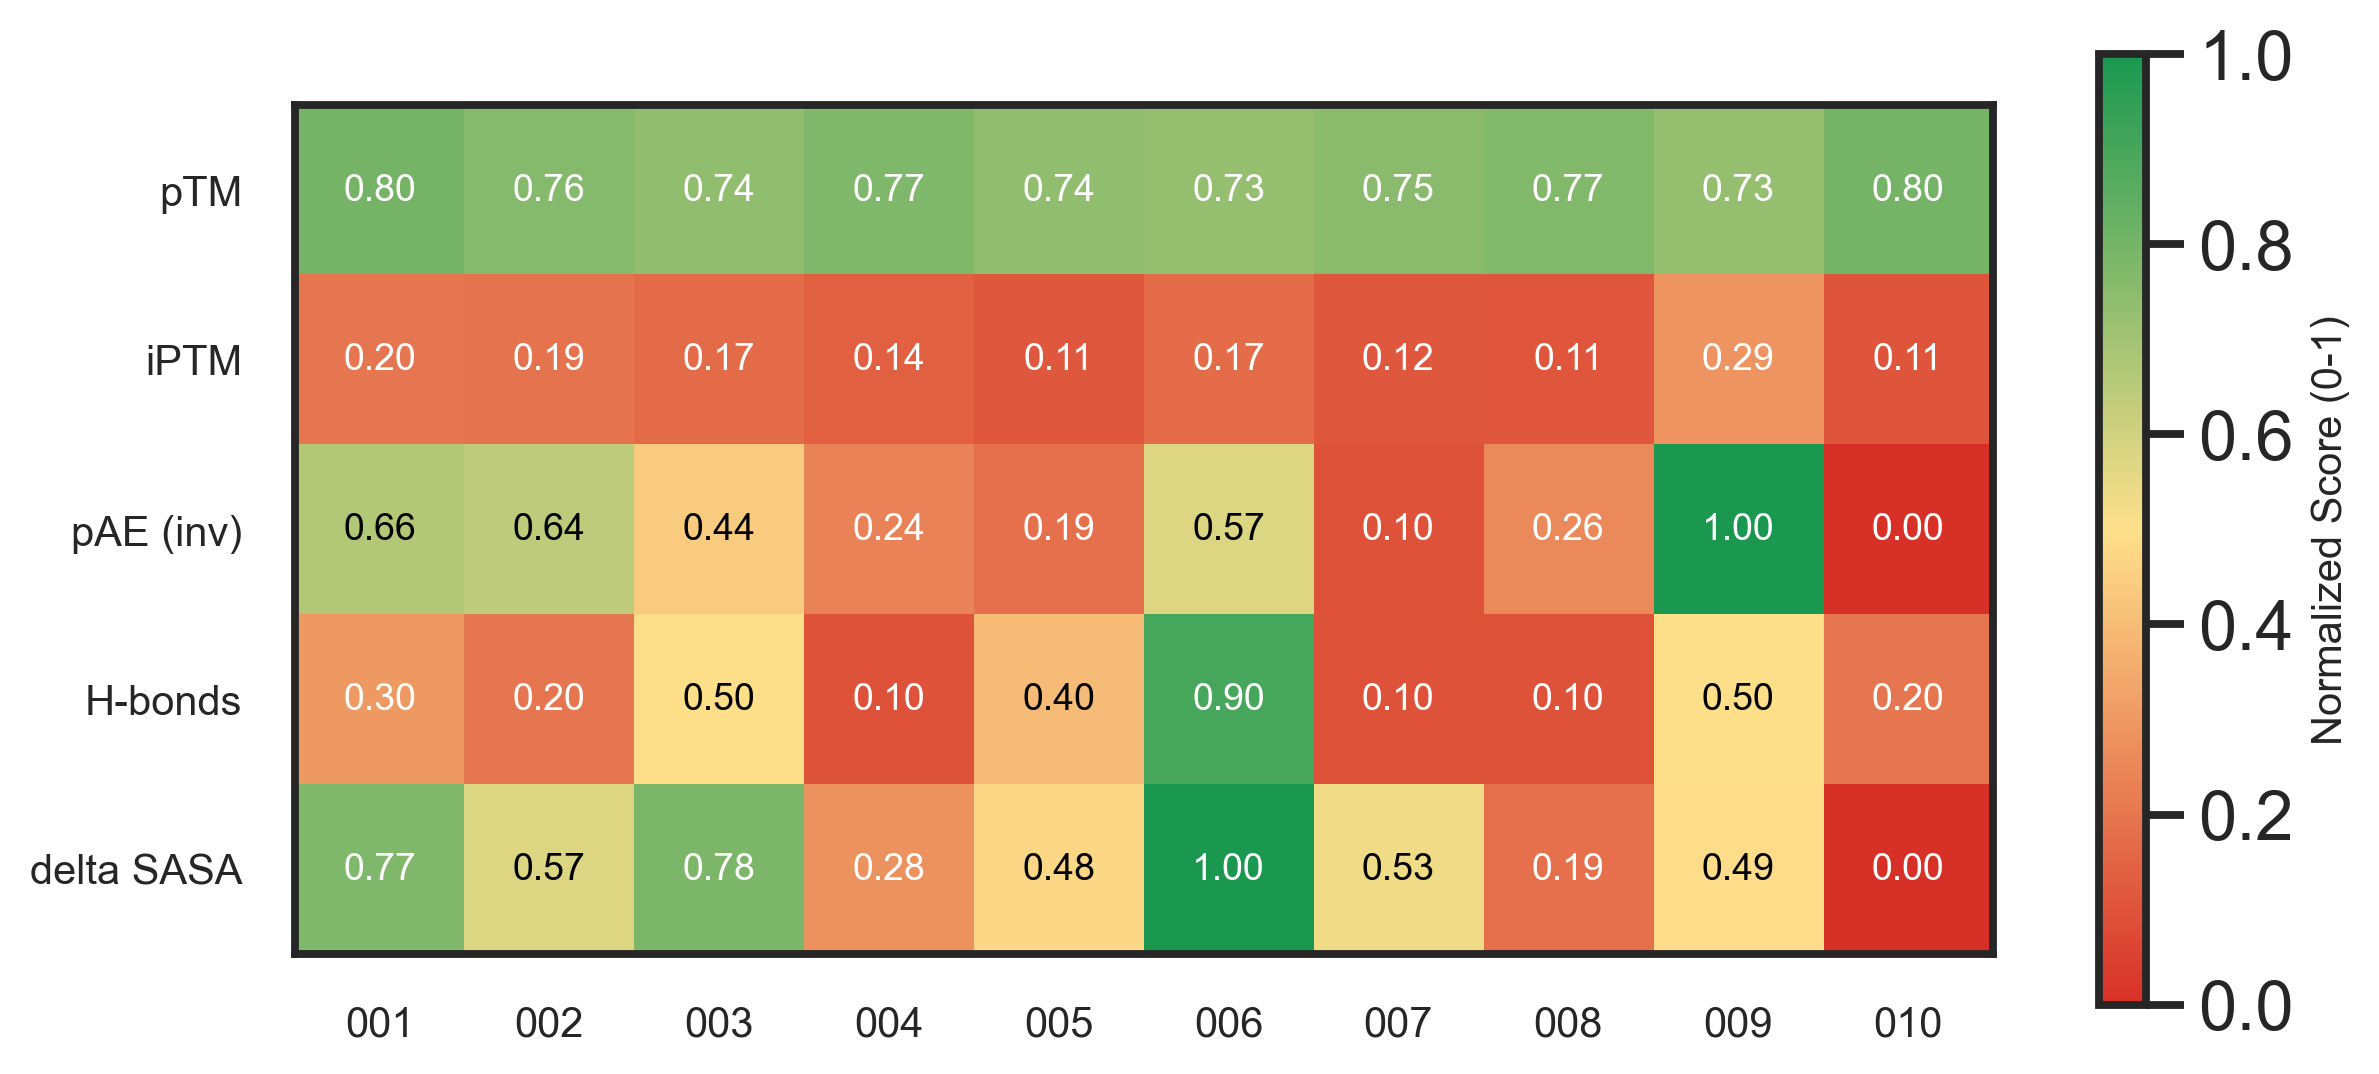


nanobody_design_statistics_table.png:


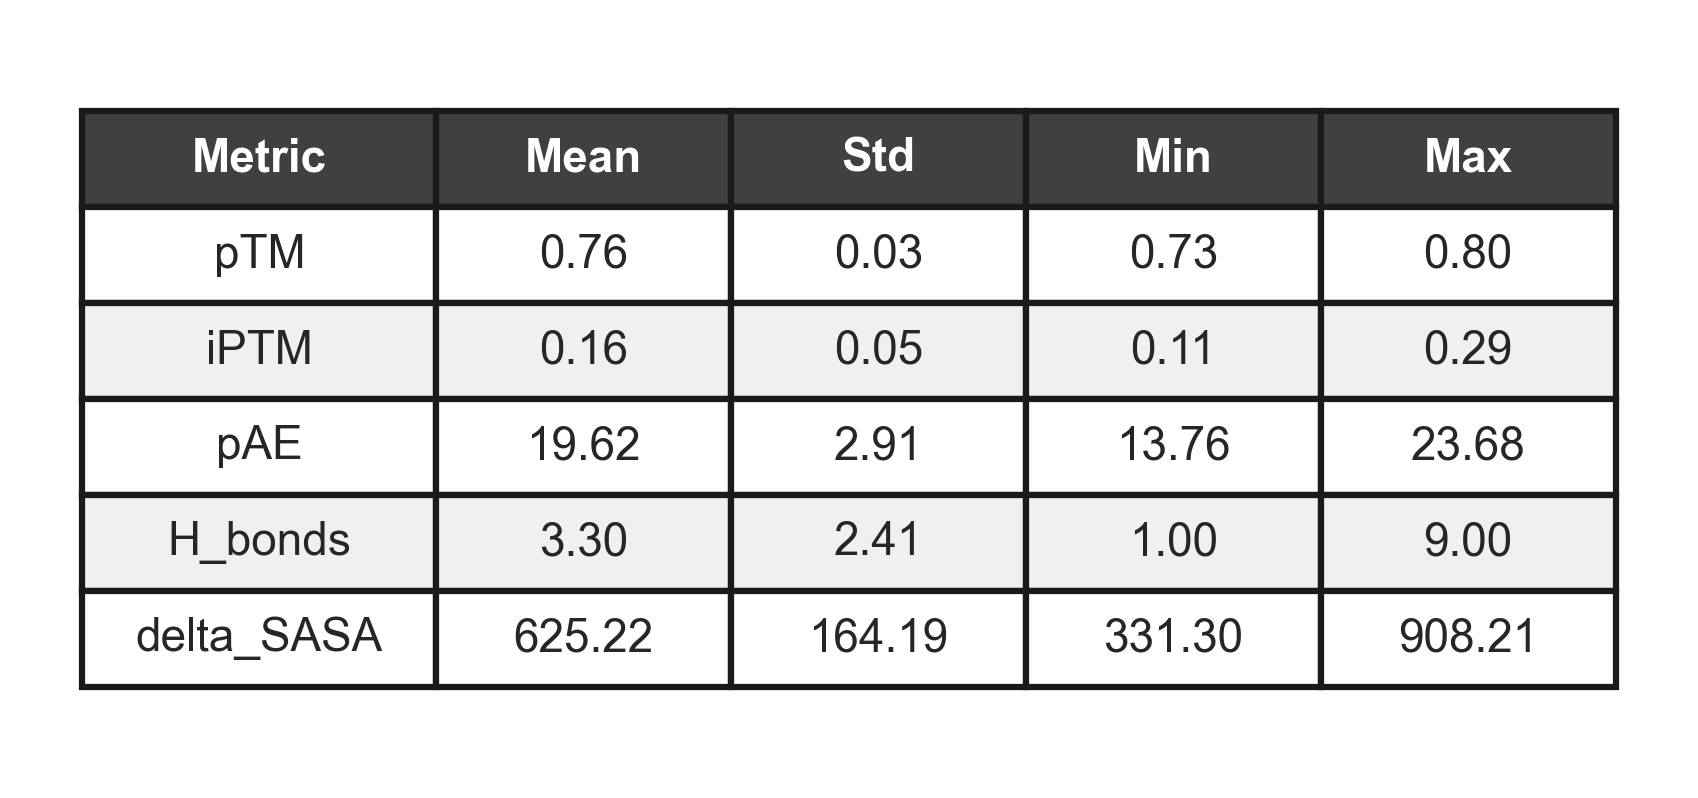


nanobody_design_quality_boxplot.png:


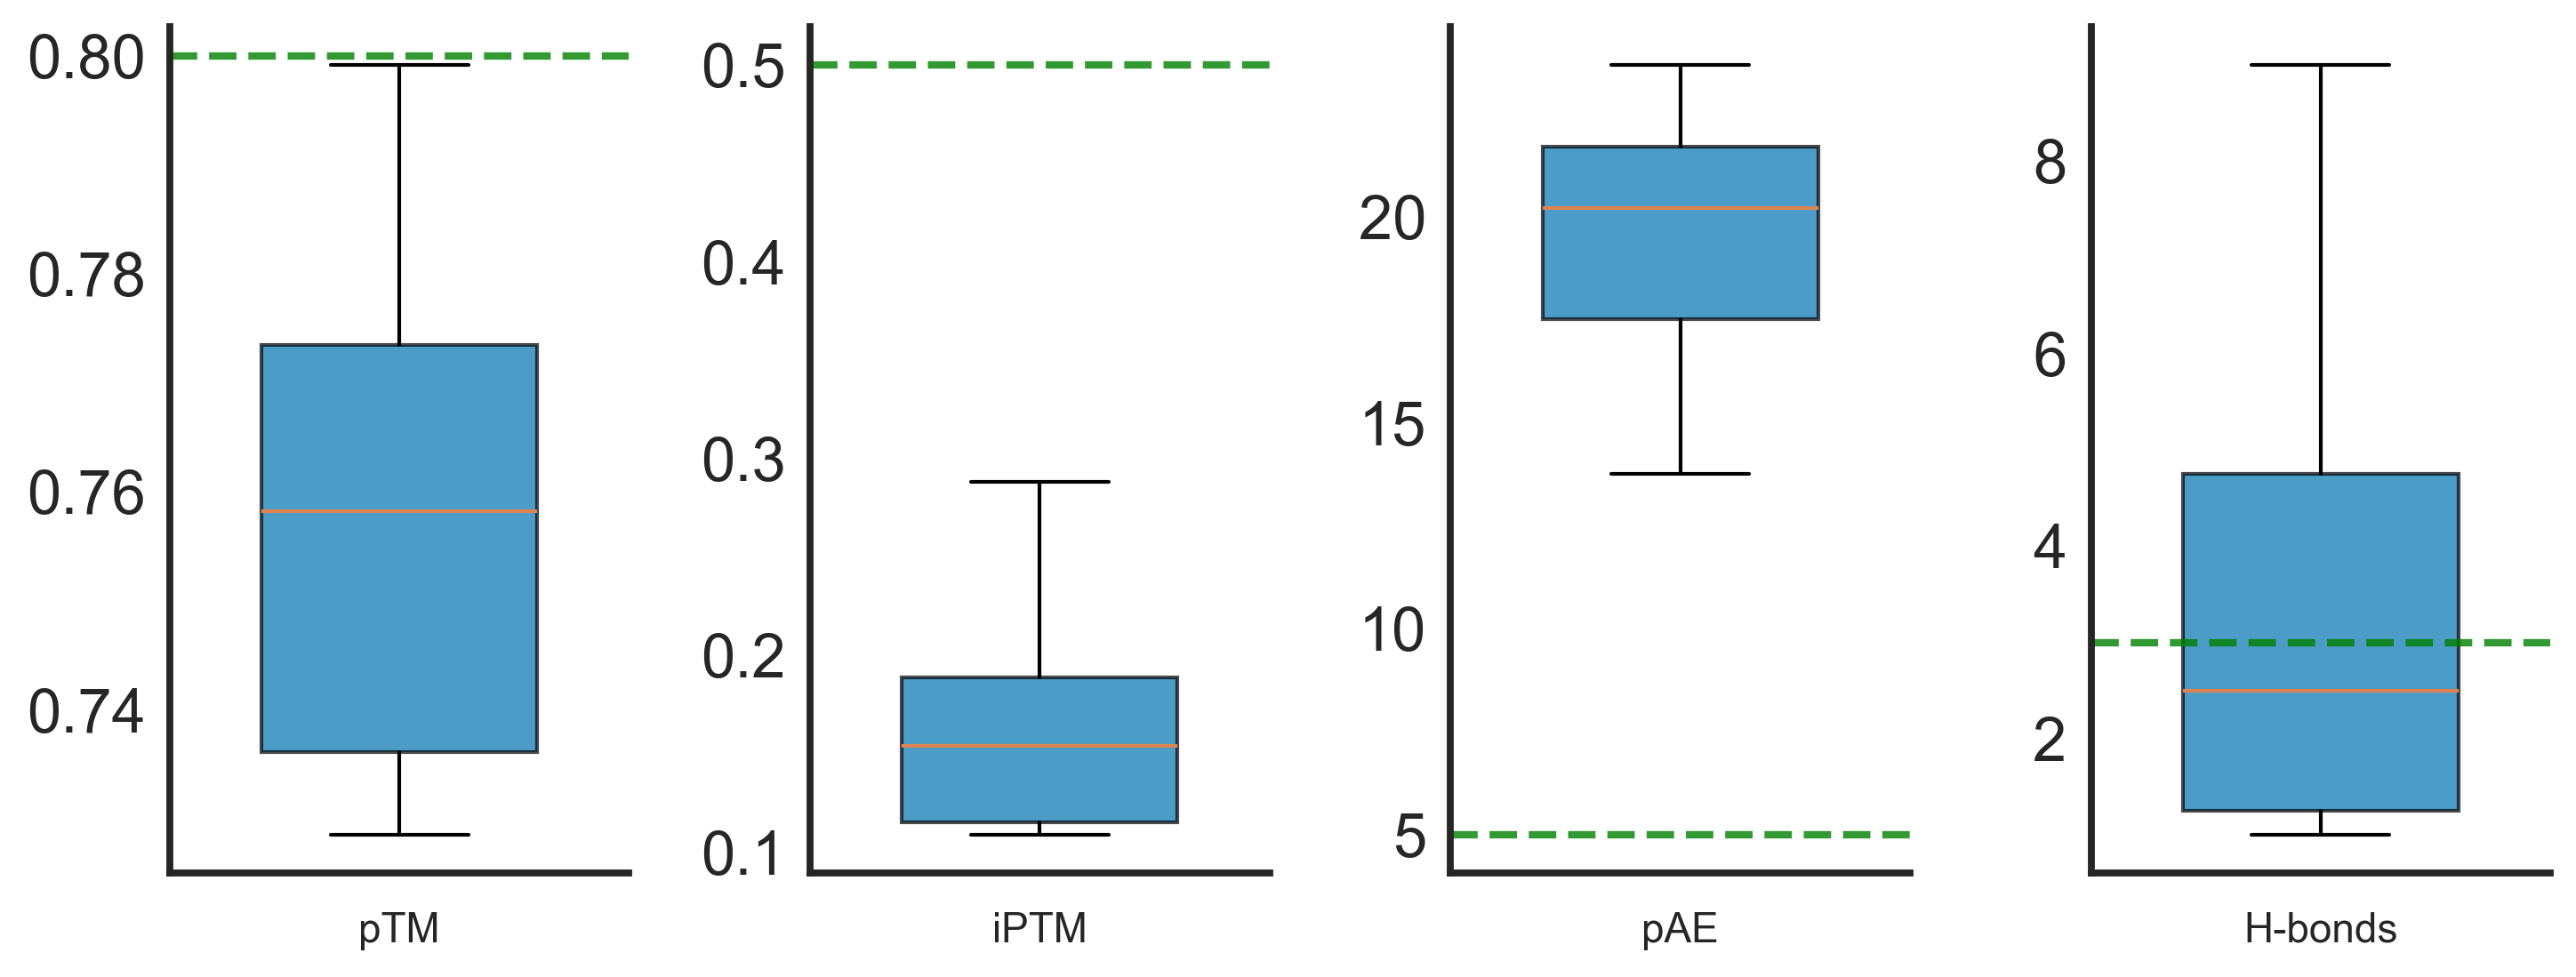


nanobody_design_interface_metrics.png:


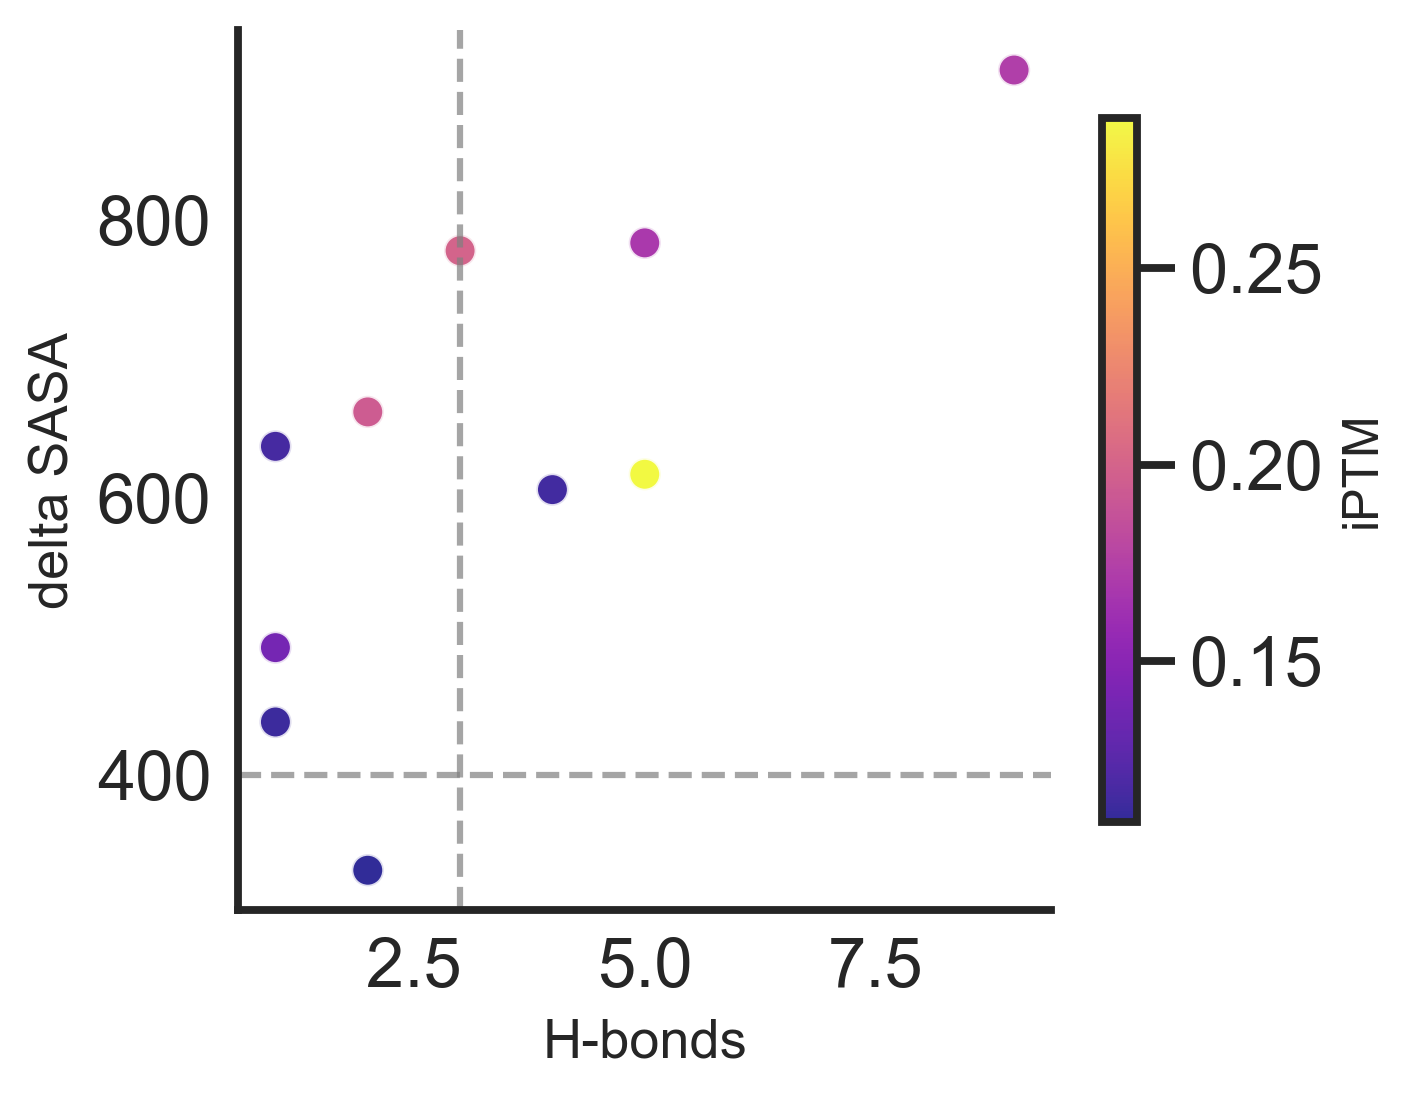


nanobody_design_top5_designs.png:


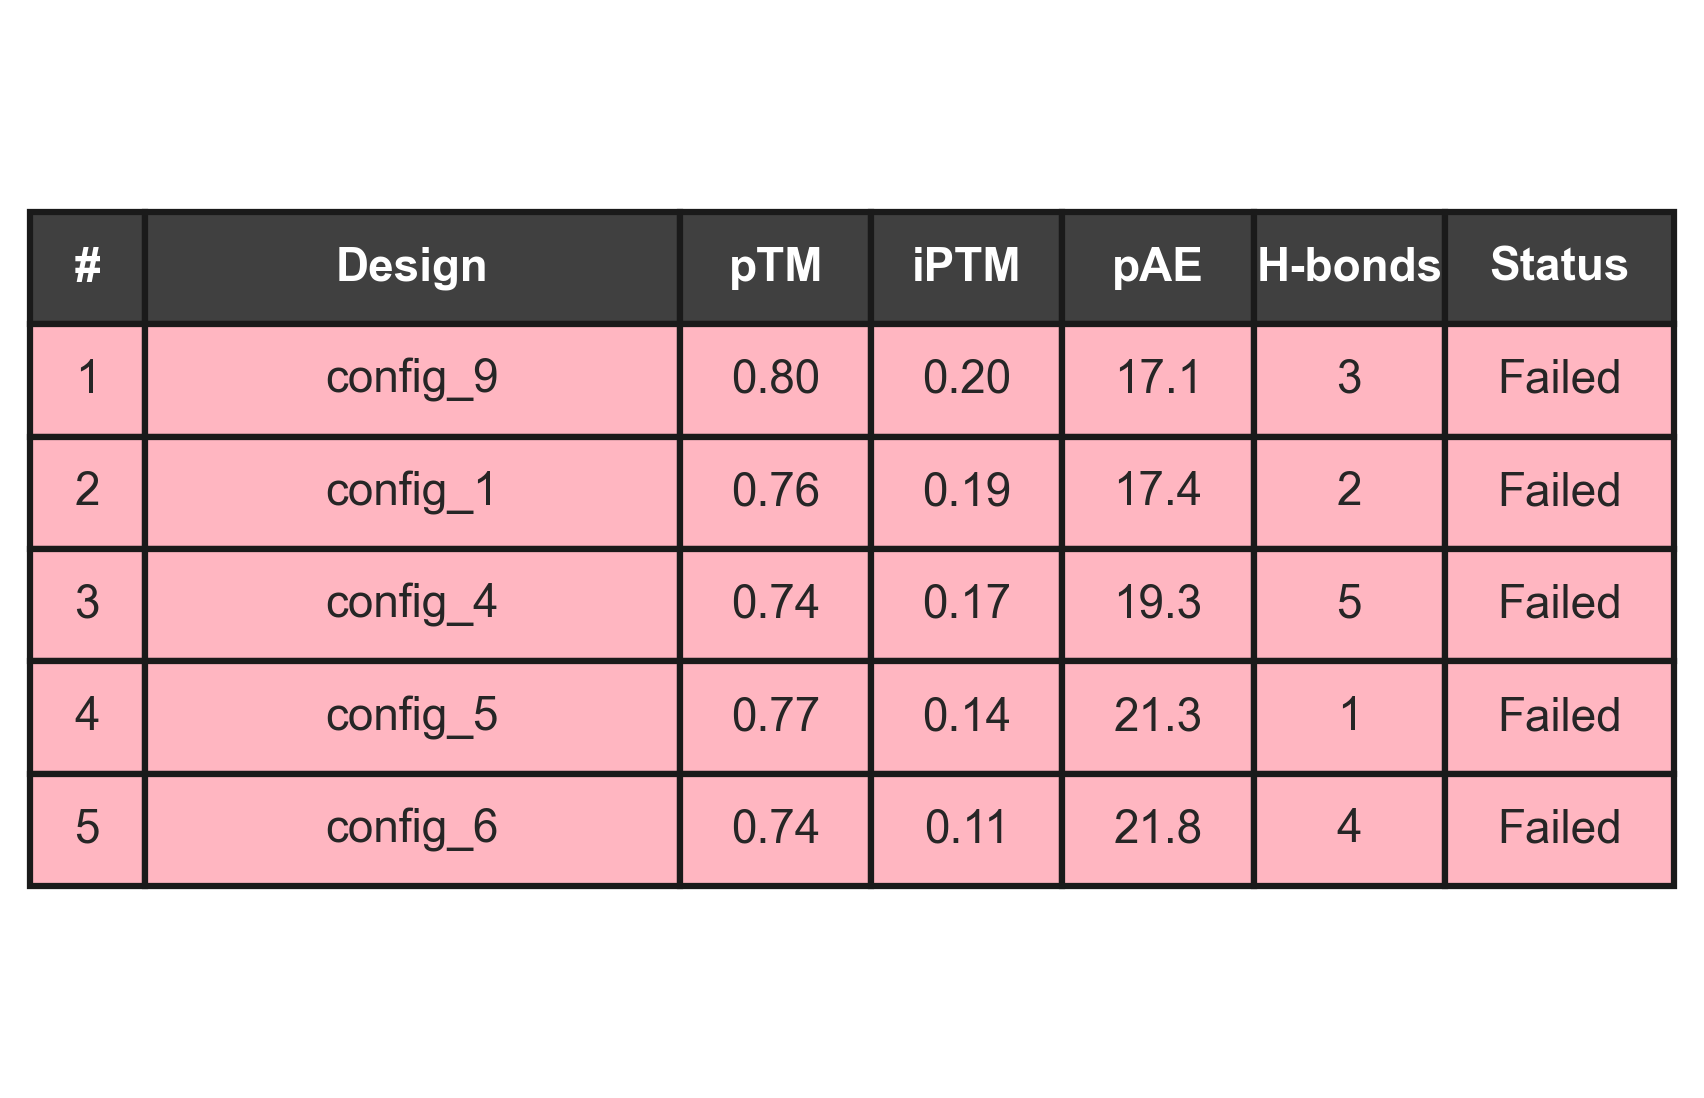


nanobody_design_correlation.png:


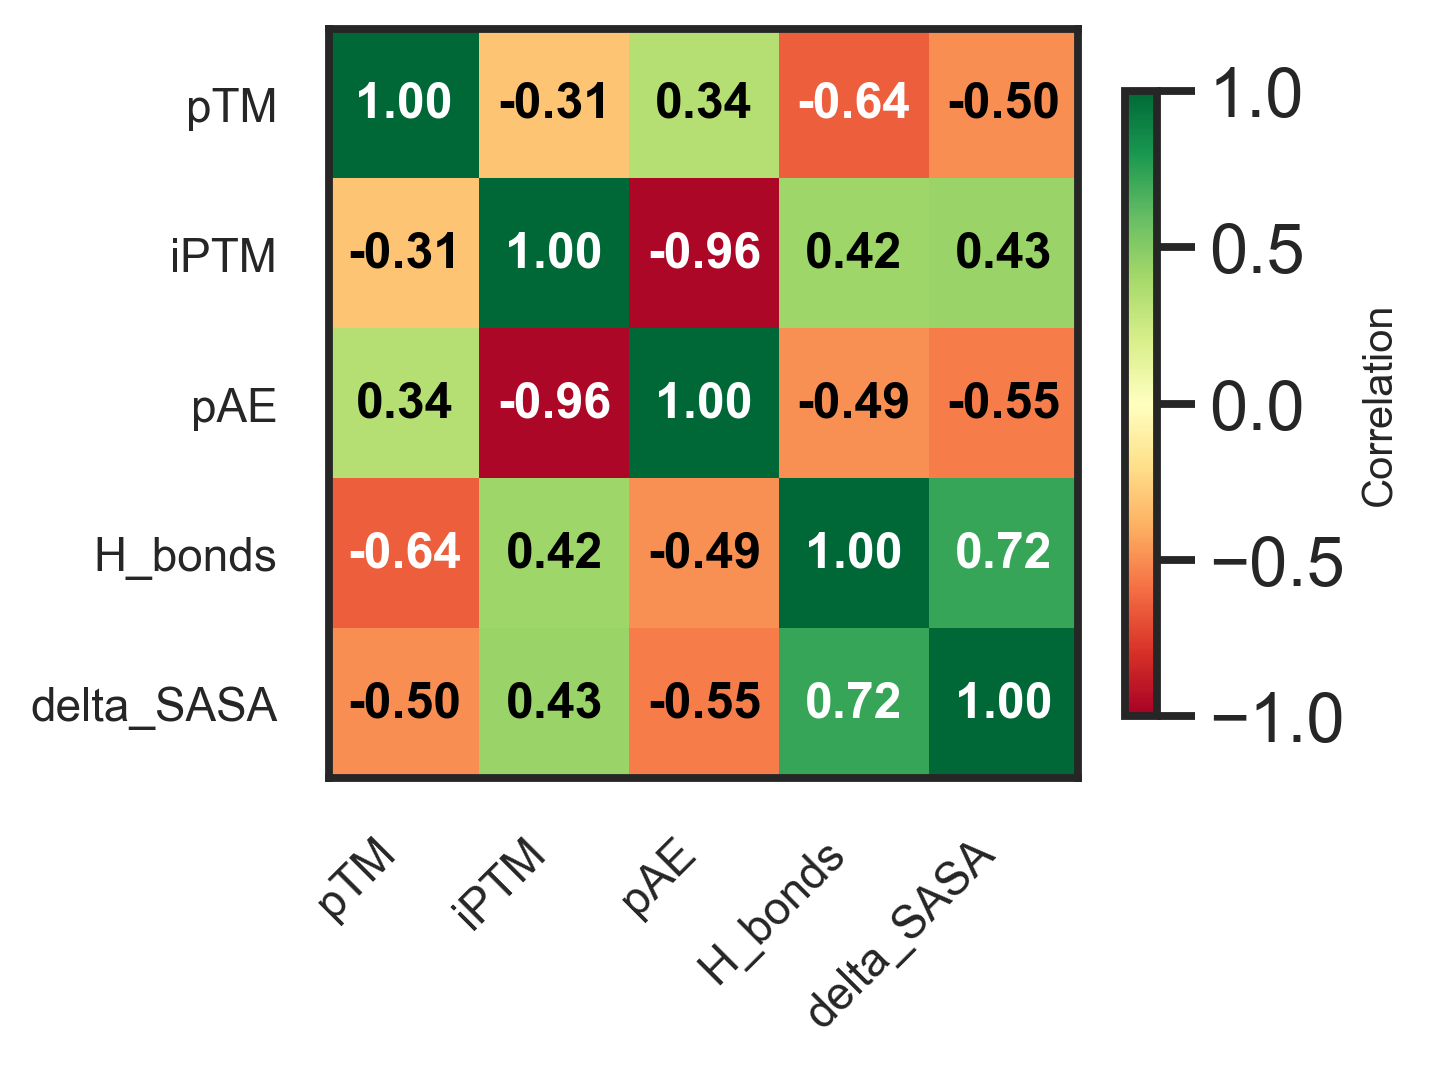


Elapsed: 9.5s


In [12]:
import time
_t0 = time.time()

VIZ_SCRIPT = os.path.join(REPO_DIR, "workflow-skills", "scripts", "nanobody_design_viz.py")
designs_dir = os.path.join(RESULTS_DIR, "designs")

# Pre-check: verify job completed and has design outputs
import glob as glob_mod
design_files = glob_mod.glob(os.path.join(designs_dir, "**/*.cif"), recursive=True) + \
               glob_mod.glob(os.path.join(designs_dir, "**/*.pdb"), recursive=True)
stats_files = glob_mod.glob(os.path.join(RESULTS_DIR, "**/*stats*.csv"), recursive=True) + \
              glob_mod.glob(os.path.join(RESULTS_DIR, "**/*metrics*.csv"), recursive=True)

if not design_files:
    print("WARNING: No design structure files (CIF/PDB) found.")
    print(f"  Check job status: the BoltzGen job may still be running or may have failed.")
    print(f"  Re-run Step 4 (Monitor) to check progress.")
    print(f"  Output dir: {designs_dir}")
elif not stats_files:
    print(f"Found {len(design_files)} design structures but no metrics CSV files.")
    print("BoltzGen may not produce a separate metrics CSV — listing design files instead:")
    for f in sorted(design_files):
        print(f"  {os.path.relpath(f, RESULTS_DIR)}")
    print(f"\nSkipping visualization (no stats CSV to plot).")
else:
    # Install viz deps if needed
    run_cmd("pip install -q matplotlib seaborn scipy Pillow pandas")

    # Generate separate figures + merged summary
    rc = run_cmd(f"python {VIZ_SCRIPT} {RESULTS_DIR}")

    if rc == 0:
        # Display figures inline
        from IPython.display import display, Image

        figures_dir = os.path.join(RESULTS_DIR, "figures")
        summary_png = os.path.join(figures_dir, "nanobody_design_summary.png")
        if os.path.exists(summary_png):
            print("\nMerged summary figure:")
            display(Image(filename=summary_png, width=900))

        fig_names = [
            "nanobody_design_quality_score.png",
            "nanobody_design_structure_quality.png",
            "nanobody_design_normalized_heatmap.png",
            "nanobody_design_statistics_table.png",
            "nanobody_design_quality_boxplot.png",
            "nanobody_design_interface_metrics.png",
            "nanobody_design_top5_designs.png",
            "nanobody_design_correlation.png",
        ]
        for fname in fig_names:
            fpath = os.path.join(figures_dir, fname)
            if os.path.exists(fpath):
                print(f"\n{fname}:")
                display(Image(filename=fpath, width=500))
    else:
        print("\nVisualization script failed. Check the error above.")

print(f"\nElapsed: {time.time() - _t0:.1f}s")

---
## Instructions & Troubleshooting

### Workflow Overview

This notebook uses BoltzGen to design nanobody CDR regions through an async job pipeline:

1. **Prepare Config** — Create a YAML configuration with target CIF and nanobody scaffolds
2. **Validate Config** — Verify the configuration is correct before submission
3. **Submit Job** — Launch an async GPU design job (nanobody-anything protocol)
4. **Monitor Progress** — Poll job status and view logs
5. **Retrieve Results** — Download designed nanobody structures and metrics
6. **Visualize** — Generate quality assessment figures
7. **Download** — Package results for sharing

### Input Format

- **Target CIF** — CIF or PDB file with target protein structure
- **Target chain** — Chain ID to design nanobody against (e.g., `"B"`)
- **Nanobody scaffolds** — YAML files defining framework regions (optional, BoltzGen has defaults)
- **Budget** — Computational budget controlling design diversity (typical: 1–5)

### Common Issues

| Problem | Solution |
|---------|---------|
| `boltzgen_mcp` not found | Run `pmcp install boltzgen_mcp` to pull Docker image |
| Job stuck in pending | Check GPU availability and Docker GPU runtime |
| Config validation fails | Verify chain IDs exist in CIF; check file paths are absolute |
| Low quality designs (low pTM/iPTM) | Increase budget parameter; try different scaffolds |
| GPU out of memory | Reduce num_designs; ensure sufficient GPU memory (~8GB) |
| Job ID not captured | Manually set `job_id = 'your-id'` from Step 3 output |
| Docker image pull timeout | Re-run `pmcp install boltzgen_mcp` (large image) |
| Scaffold files not found | Scaffolds are optional; BoltzGen has built-in defaults |

### Quality Thresholds

| Metric | Good | Acceptable | Description |
|--------|------|------------|-------------|
| pTM | \u22650.8 | \u22650.6 | Predicted TM-score (higher is better) |
| iPTM | \u22650.5 | \u22650.3 | Interface pTM score (higher is better) |
| pAE | \u22645\u00c5 | \u226410\u00c5 | Predicted aligned error (lower is better) |
| H-bonds | \u22653 | \u22651 | Interface hydrogen bonds (higher is better) |
| delta SASA | \u2265400 | \u2265200 | Buried surface area (higher is better) |

### References

- [BoltzGen](https://github.com/jwohlwend/boltzgen) — Generative model for nanobody design
- [Boltz2](https://github.com/jwohlwend/boltz) — Structure prediction
- [Nanobody Resources (SAbDab)](https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/) — Nanobody databases
- [ProteinMCP](https://github.com/charlesxu90/ProteinMCP) — This project